# New boxplot

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
from argparse import Namespace
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from models.earlyrnn import EarlyRNN
import torch
import os
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, recall_score, precision_score


import datetime
import seaborn
import datetime
import breizhcrops as bzh
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

os.environ['MPLCONFIGDIR'] = '/myhome'
from utils.plots import plot_label_distribution_datasets
from utils.helpers_config import set_up_config, save_config, print_config
from utils.test.helpers_testing import get_test_stats_from_model, load_test_dataset, save_test_stats
from utils.plots_test import plots_all_figs_at_test
import matplotlib.pyplot as plt
from utils.test.load_model import get_all_runs, get_loaded_model_and_criterion, get_model_and_model_path
from utils.helpers_mu import get_mus_from_config
from utils.results_analysis.extract_video import download_images, add_files_to_images, save_video
import argparse
from utils.test.plot_maps import plot_map_stop_date, plot_map_prediction_at_date, plot_map_target_at_date, classes_cmap, \
    plot_map_doy_stop, plot_map_correct, plot_map_predictions_at_t_stop, plot_map_targets, plot_map_table
from utils.plots_test import plot_confusion_matrix

load model

In [3]:
local_dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")


In [4]:
run_name = "v1"
print(f"Load model from run '{run_name}'")

# ## Download the model from wandb 
entity, project = "aurenore", "MasterThesis"
runs_df, runs = get_all_runs(entity, project)

# get the run with name:
run_idx = runs_df[runs_df.name == run_name].index[0]
run = runs[run_idx]
run_config = argparse.Namespace(**run.config)
model_artifact, model_path = get_model_and_model_path(run)

# get and save the config
config_path = save_config(model_path, run)
print_config(run)
args  = set_up_config(run_config)
args.dataroot = local_dataroot 

Load model from run 'v1'


wandb:   1 of 1 files downloaded.  


config file saved at:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-5dazxzo8-model.pth-v27\config.json
-------------------------------------------------- Configuration: --------------------------------------------------
mu: 150
mus: [122, 72, 102, 103, 150, 150, 150]
loss: daily_reward_piecewise_lin_regr
alpha: 1
device: cuda
epochs: 100
factor: v1
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /home/amauron/elects/data/elects_data
p_thresh: 0.7
patience: 30
snapshot: /home/amauron/elects/data/elects_snapshots/model.pth
batchsize: 128
corrected: True
alpha_decay: [1, 0.4]
hidden_dims: 128
loss_weight: balanced
weight_decay: 0
backbonemodel: LSTM
class_weights: [0.04731182754039765, 0.02670983411371708, 0.14316703379154205, 0.01290007308125496, 1, 0.011567785404622557, 0.010797104798257353]
decision_head: day
learning_rate: 0.001
nb_parameters: 264994
sequencelength: 365
validation_set: valid
daily_timestamps: True
day_head_init_bia

In [5]:
# ----------------------------- LOAD DATASET -----------------------------
# Set the sequence length to 150 like in the original paper.
sequencelength_test = run_config.sequencelength
args.preload_ram = True
test_ds, nclasses, class_names, input_dim = load_test_dataset(args, sequencelength_test)

2493572704 2493572704


loading data into RAM: 100%|██████████| 2463/2463 [00:01<00:00, 1331.35it/s]


1555075632 1555075632


loading data into RAM: 100%|██████████| 36915/36915 [00:21<00:00, 1702.55it/s]


class names: ['barley' 'wheat' 'rapeseed' 'corn' 'orchards' 'permanent meadows'
 'temporary meadows']


get tests results

In [24]:
# ## Load the models and the criterions
mus = get_mus_from_config(run_config)
model, criterion = get_loaded_model_and_criterion(run, nclasses, input_dim, mus=mus)

# ## Test the model on the test dataset
test_stats, stats = get_test_stats_from_model(model, test_ds, criterion, run_config)

wandb:   1 of 1 files downloaded.  
c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\..\utils\test\load_model.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(run_config.class_weights)


loss daily_reward_piecewise_lin_regr selected, mus set to tensor([122,  72, 102, 103, 150, 150, 150])
model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-5dazxzo8-model.pth-v27
The model has 264,994 trainable parameters.
weights moved to device cuda


## boxplot with correct vs incorrect predictions

In [32]:
stats['predictions_at_t_stop'][:, 0]

array([0, 6, 6, ..., 5, 5, 5], dtype=int64)

In [51]:
import seaborn as sns
import warnings
PALETTE=sns.color_palette("colorblind")
from data import LABELS_NAMES

def boxplot_stopping_times(doy_stop, stats, fig, ax, labels_names=LABELS_NAMES, colors=PALETTE, epoch=None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13)]
        months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
        
        stats["correct_targets"] = stats["targets"][:,0].astype(float)
        for target_i in range(len(labels_names)):
            # for the target_i class, if the correct target should have been target_i but is not, set the value to target_i+0.5
            stats["correct_targets"][(stats["targets"][:,0] == target_i) & (stats['predictions_at_t_stop'][:, 0] != target_i)] = target_i + 0.5
            
        colors = colors[:len(labels_names)]
        new_palette = [colors[i//2] for i in range(2*len(labels_names))]
        sns.boxplot(x=doy_stop,y=stats['correct_targets'],orient="h",ax=ax,showfliers=False, palette=new_palette)
        ax.set_yticks(range(2*len(labels_names)))
        ylabels = []
        for label in labels_names: 
            ylabels.append(label)
            ylabels.append("wrong "+label)
        ax.set_yticklabels(ylabels, fontsize=16)
        ax.set_xlabel("day of year", fontsize=16)

        ax.xaxis.grid(True)
        ax.set_xticks(doys_months)
        ax.set_xticklabels(months, ha="left")

        sns.despine(left=True)
        # if epoch is not None, write the epoch number on the plot at the top right corner
        if epoch is not None:
            ax.text(0.99, 0.99, f"Epoch {epoch}", transform=ax.transAxes, ha='right', va='top', fontsize=16)
        fig.tight_layout()

    return fig, ax

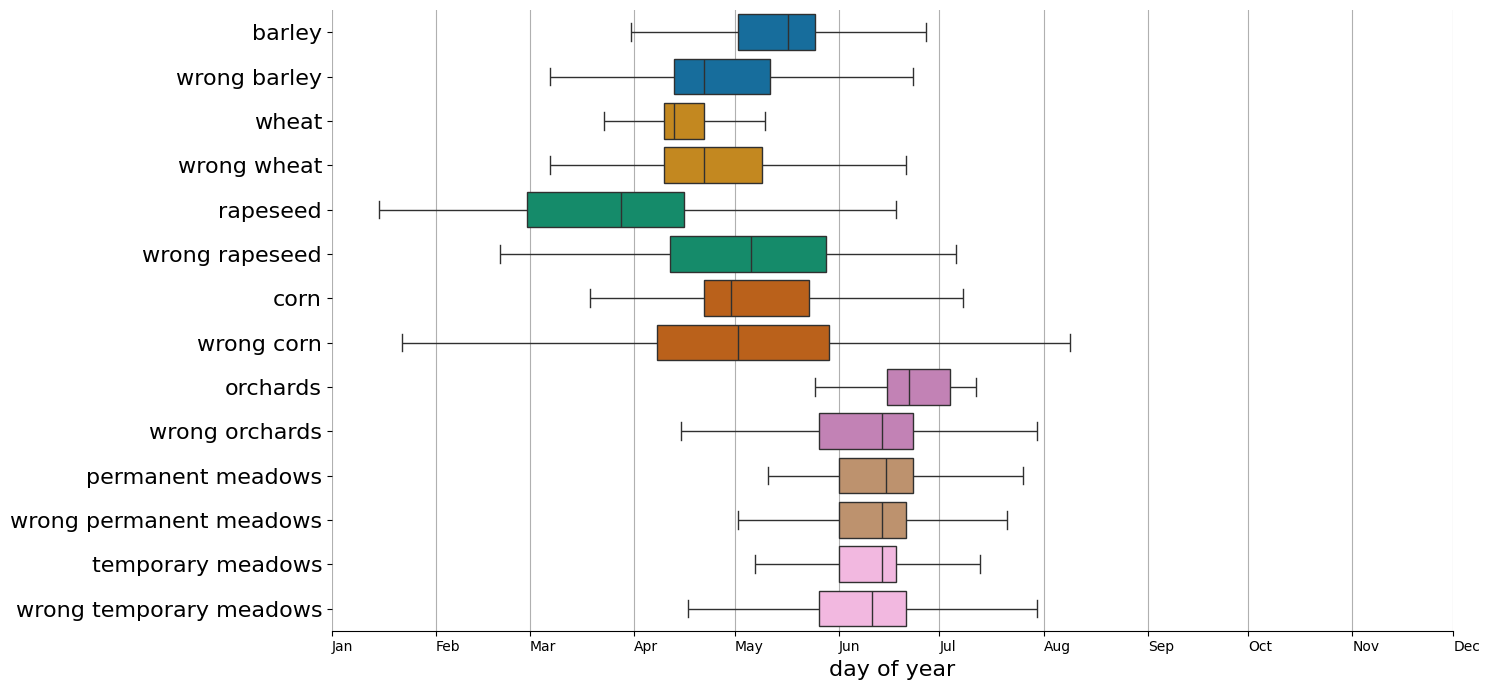

In [52]:
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
if args.daily_timestamps:
    doys_stop = stats["t_stop"].squeeze()
else: 
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats.copy(), fig_boxplot, ax_boxplot, class_names)